# Hybrid Deep Learning Model
use self organising maps to identify fraud then train a neural network to rank customers on the likelyhood of cheating.

## import libaries 

In [21]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.__version__

'2.11.0'

## import dataset

In [3]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

## feature scale

In [4]:
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

## unsupervised SOM Training

In [6]:
som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)

## visualise SOM results

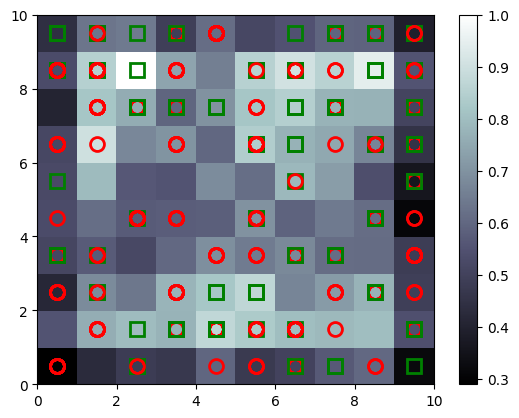

In [7]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

## find Fraud

In [9]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(6,8)], mappings[(5,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

#potential clients
print(len(frauds))
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

26
Fraud Customer IDs
15605791
15565714
15655464
15608688
15609070
15650313
15565996
15581871
15645571
15620103
15642063
15588019
15654760
15575146
15666297
15611794
15651868
15716082
15651460
15672637
15592999
15752344
15673907
15611409
15636454
15608916


## create matrix of features for ann training dataset
Go from unsupervised to supervised deep learning

In [10]:
#independent variables
customers = dataset.iloc[:,1:].values

In [11]:
#dependent variable
is_fraud = np.zeros(len(dataset)) #690 zeros initialised
#put 1s for customers that cheated
for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds: #customer id
        is_fraud[i] = 1

## Train neural network

In [14]:
#feature scale
sc = StandardScaler()
customers = sc.fit_transform(customers)

In [22]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(customers, is_fraud, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (552, 15)
y_train shape: (552,)
X_test shape: (138, 15)
y_test shape: (138,)


In [23]:
#initialise the artificial neural network
ann = tf.keras.models.Sequential()
#add input + first hidden layer
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))
#add output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [24]:
#compile the ann with adams with accuracy for evaluation
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
#train ann
#ann.fit(customers, is_fraud, batch_size = 1, epochs = 10)
ann.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10


552/552 [==============================] - 1s 1ms/step - loss: 0.7072 - accuracy: 0.7101
Epoch 2/10
552/552 [==============================] - 1s 1ms/step - loss: 0.3834 - accuracy: 0.9384
Epoch 3/10
552/552 [==============================] - 1s 1ms/step - loss: 0.2855 - accuracy: 0.9656
Epoch 4/10
552/552 [==============================] - 1s 1ms/step - loss: 0.2302 - accuracy: 0.9692
Epoch 5/10
552/552 [==============================] - 1s 1ms/step - loss: 0.1916 - accuracy: 0.9692
Epoch 6/10
552/552 [==============================] - 1s 1ms/step - loss: 0.1644 - accuracy: 0.9692
Epoch 7/10
552/552 [==============================] - 1s 1ms/step - loss: 0.1432 - accuracy: 0.9692
Epoch 8/10
552/552 [==============================] - 1s 1ms/step - loss: 0.1292 - accuracy: 0.9692
Epoch 9/10
552/552 [==============================] - 1s 1ms/step - loss: 0.1196 - accuracy: 0.9710
Epoch 10/10
552/552 [==============================] - 1s 1ms/step - loss: 0.1121 - accuracy: 0.9692


## evaluate neural network

In [26]:
# Evaluate the ANN on the test data
eval_result = ann.evaluate(X_test, y_test)
print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])

5/5 [==============================] - 1s 2ms/step - loss: 0.1910 - accuracy: 0.9348
Test loss: 0.19100476801395416
Test accuracy: 0.9347826242446899


## predict test set results with trained ANN

In [27]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]
print(y_pred)

22/22 [==============================] - 0s 1ms/step
[[1.57997850e+07 2.31537661e-06]
 [1.56214230e+07 2.74300710e-05]
 [1.57063940e+07 1.22541533e-04]
 ...
 [1.56089160e+07 3.81312847e-01]
 [1.56514600e+07 4.33396727e-01]
 [1.56364540e+07 4.70849127e-01]]
